In [11]:
import pandas as pd
from cvxpy import *
import numpy as np
import scipy
from scipy.sparse import csr_matrix, block_diag, bmat
timeseries = pd.read_csv("insilico_size10_1_timeseries.tsv", sep='\t', header=0)

#the first column of timeseries is time, each experiment 21 rows
timeseries = np.array(timeseries)

In [12]:
dif_time = np.unique(timeseries[:,0])[1] - np.unique(timeseries[:,0])[0]
M = np.unique(timeseries[:,0]).shape[0]
p = timeseries.shape[0]/M
M =10
p =5

In [13]:
timeseries = timeseries[:,1:]
n = timeseries.shape[1]

In [14]:
x = timeseries.copy()
no_pertrub = x[11:21,:]
for i in range(1,p):
    no_pertrub = np.vstack((no_pertrub,x[i*21+11:i*21+21,:]))

In [15]:
def deriv(N=M,timeseries=no_pertrub):
    h = 1./dif_time
    data = np.array([np.ones(N)*(-2), np.ones(N), np.ones(N)])
    B = scipy.sparse.spdiags(data, np.array([0, -1, 1]), N, N)
    B *= h**2
    D = block_diag([B]*p)
    x = timeseries.copy()
    y = D.dot(x)
    return y.reshape(M*p*n,1) 

In [16]:
deriv().shape

(500, 1)

In [17]:
def Phi_b(i, j, timeseries = no_pertrub):
    Fb_self = timeseries[i*M+j,:]
    Fb_connect = Fb_self/(1+Fb_self)
    #for i in range (n):
        #Fb = np.hstack((Fb_self[i],Fb_connect[:i]))
        #Fb = np.hstack((Fb,Fb_connect[i+1:]))  
    Fb = np.hstack((Fb_self,Fb_connect))
    Fb = np.hstack((Fb,Fb_connect))
    I = np.eye(n)
    Phi_b = np.kron(Fb, I)
    return Phi_b
    

In [18]:
def matrix_Phi(timeseries = no_pertrub):
    phis = []
    for i in range(p):
        for j in range(M):
            phis.append(Phi_b(i,j))
    
    result = block_diag(phis)
    return result

In [86]:
Q = Variable(3*n**2,M*p)
lam1 = 0.05
lam_TV = 0.8
lam_constr = 0.3
TV = 0
for i in range(2,M*p):
    #TV += (sum_squares(Q[:,i] - Q[:,i-1]))
    TV += norm((Q[:,i] - Q[:,i-1]),1)
    constr = norm(deriv() - matrix_Phi()*reshape(Q.T,3*n**2*M*p,1),1)
obj = Minimize(lam_TV*TV + lam1 * norm(Q, 1) + lam_constr*constr)
constraints = []

In [87]:
prob = Problem(obj, constraints)
prob.solve()  

0.008245239242214394

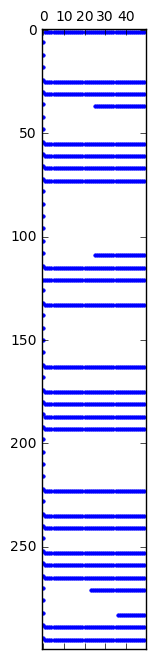

In [88]:
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
plt.figure(figsize=(2, 8))
A = csc_matrix(Q.value )
plt.spy(A, precision=1e-9, aspect='equal', marker='.', markersize=5)
plt.show()

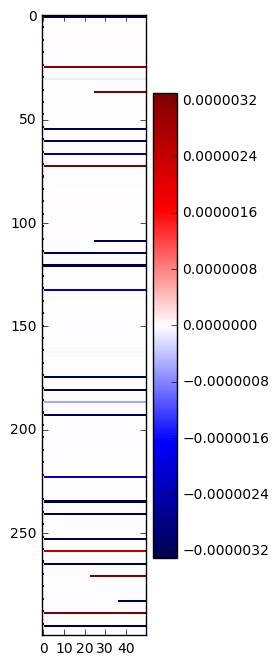

In [89]:
d=Q.value
vmin = max(-d.min(), d.max())/100.
plt.figure(figsize=(2, 8))
plt.imshow(d, cmap = 'seismic' ,interpolation='nearest', vmin=-vmin, vmax=vmin)
plt.colorbar()
plt.show()